In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from core.env import OPENAI_API_KEY
from core.env import LANGFUSE_SECRET_KEY, LANGFUSE_PUBLIC_KEY, LANGFUSE_HOST
os.environ["LANGFUSE_HOST"] = LANGFUSE_HOST
os.environ["LANGFUSE_SECRET_KEY"] = LANGFUSE_SECRET_KEY
os.environ["LANGFUSE_PUBLIC_KEY"] = LANGFUSE_PUBLIC_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

2024-11-22 05:42:22.803 | INFO     | core.env:<module>:13 - Loaded environment variables from /home/knakanishi_woolworths_com_au/idx-ai-katas-2024/8_code/ai-backend/local/envs/.env.dev


In [3]:
from core.agents.agent_graph import app
import uuid
from langchain_core.messages import HumanMessage
from langfuse.callback import CallbackHandler
import pandas as pd
import ast
from deepeval import evaluate
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric
from deepeval.test_case import LLMTestCase
import nest_asyncio
nest_asyncio.apply()

/opt/conda/envs/katas/lib/python3.11/site-packages/deepeval/__init__.py:53: UserWarning: You are using deepeval version 1.5.8, however version 1.5.9 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


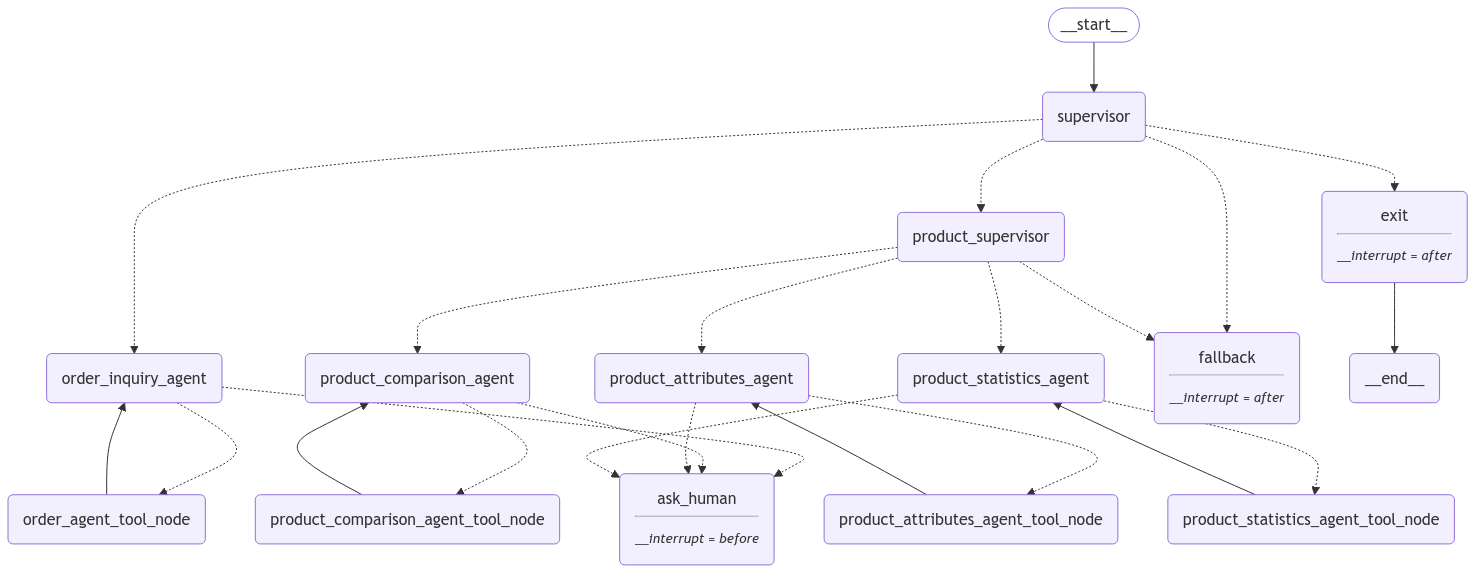

In [4]:
from IPython.display import Image
Image(app.get_graph(xray=True).draw_mermaid_png())

# Run the Graph for Evaluation

The focus of this notebook is to evaluate the performance of the AI Agent team on the Return Eligibility Test Set.
It demonstrates how to run the graph for evaluation and how to use DeepEval to evaluate the performance of the model.

For simplicity, we will only evaluate 10 LLM-generated test cases for each model.

We'll be using the following models:
- Gemini Flash 
- Claude Sonnet 3.5
- gpt-4o-mini

We'll be using the following metrics:
- Answer Relevancy
    - This metric evaluates whether the LLM's answer is relevant to the question.
- Faithfulness
    - This metric evaluates whether the LLM's answer is faithful to the given context (here we provide the ground truth context).



## Execute with Gemini Flash

In [ ]:
model = "gemini-1.5-flash-002"

df = pd.read_excel("../../data/test_sets/return-eligibility-test-set.xlsx")
tags = list(df['set'].unique())
df['customer_id'] = df.apply(lambda x: ast.literal_eval(x['context_ground_truth'])['orders'][0]['CustomerID'], axis=1)
langfuse_callback_handler = CallbackHandler(tags = tags + [model])

df['answer'] = None
for i, row in df.iterrows():
    customer_id = row['customer_id']
    question = row['question']
    thread_id = str(uuid.uuid4())
    config = {
        "configurable": {
            "customer_id": customer_id,
            "thread_id": thread_id,
            "model": model,
        },
        "callbacks": [
            langfuse_callback_handler
        ]
    }
    async for s in app.astream({"messages":[HumanMessage(content="Can you tell me more about my order?")]}, config=config, stream_mode="values"):
        pass
    df.loc[i, 'answer'] = s['messages'][-1].content

df.to_excel("../../data/eval_sets/return-eligibility-test-set-with-answers-gemini.xlsx", index=False)

## Execute with Claude Sonnet

In [ ]:
model = "claude-3-5-sonnet-v2@20241022"

df = pd.read_excel("../../data/test_sets/return-eligibility-test-set.xlsx")
tags = list(df['set'].unique())
df['customer_id'] = df.apply(lambda x: ast.literal_eval(x['context_ground_truth'])['orders'][0]['CustomerID'], axis=1)
langfuse_callback_handler = CallbackHandler(tags = tags + [model])

df['answer'] = None
for i, row in df.iterrows():
    customer_id = row['customer_id']
    question = row['question']
    thread_id = str(uuid.uuid4())
    config = {
        "configurable": {
            "customer_id": customer_id,
            "thread_id": thread_id,
            "model": model,
        },
        "callbacks": [
            langfuse_callback_handler
        ]
    }
    async for s in app.astream({"messages":[HumanMessage(content="Can you tell me more about my order?")]}, config=config, stream_mode="values"):
        pass
    df.loc[i, 'answer'] = s['messages'][-1].content

df.to_excel("../../data/eval_sets/return-eligibility-test-set-with-answers-claude-sonnet.xlsx", index=False)

## Execute with gpt-4o-mini

In [ ]:
model = "gpt-4o-mini"

df = pd.read_excel("../../data/test_sets/return-eligibility-test-set.xlsx")
tags = list(df['set'].unique())
df['customer_id'] = df.apply(lambda x: ast.literal_eval(x['context_ground_truth'])['orders'][0]['CustomerID'], axis=1)
langfuse_callback_handler = CallbackHandler(tags = tags + [model])

df['answer'] = None
for i, row in df.iterrows():
    customer_id = row['customer_id']
    question = row['question']
    thread_id = str(uuid.uuid4())
    config = {
        "configurable": {
            "customer_id": customer_id,
            "thread_id": thread_id,
            "model": model,
        },
        "callbacks": [
            langfuse_callback_handler
        ]
    }
    async for s in app.astream({"messages":[HumanMessage(content="Can you tell me more about my order?")]}, config=config, stream_mode="values"):
        pass
    df.loc[i, 'answer'] = s['messages'][-1].content

df.to_excel("../../data/eval_sets/return-eligibility-test-set-with-answers-gpt-4o-mini.xlsx", index=False)

# Let's take a look at the answers!

In [5]:
df = pd.read_excel("../../data/eval_sets/return-eligibility-test-set-with-answers-gemini.xlsx")
print(df['answer'][0])

Certainly! To assist you better, could you please provide your Order ID?



In [6]:
df = pd.read_excel("../../data/eval_sets/return-eligibility-test-set-with-answers-gpt-4o-mini.xlsx")
print(df['answer'][0])

Your order (ID: 1588) is for a Panasonic DMC FZ1000EB Lumix bridge camera with a 25-400mm Leica DC lens and 20.1MP. The order is currently in a "Pending" status. 

Please note that this item is not eligible for return. The order was shipped on October 8, 2024.

Let me know if you have any other questions!


In [7]:
df = pd.read_excel("../../data/eval_sets/return-eligibility-test-set-with-answers-claude-sonnet.xlsx")
print(df['answer'][0])

I can see that you have an order (Order ID: 1588) for a Panasonic Lumix DMC-FZ1000EB Bridge Camera with a 25-400mm Leica DC lens and 20.1MP sensor. The order is currently in a "Pending" status and was shipped on October 8th, 2024. The camera costs $799.99. Please note that this order is not eligible for returns.

The camera features a versatile 25-400mm Leica DC lens and uses a 2-sensor based technology for high-quality imaging. It has a rating of 3.8 out of 5 based on customer reviews.

Is there anything specific about the order you'd like to know more about? Please let me know if you have any questions!


## Evaluate the performance of the models using RAGAs 2.6

In [8]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
)
import numpy as np

In [9]:
def evaluate_model_performance(path):
    df = pd.read_excel(path)
    user_inputs = []
    responses = []
    retrieved_contexts = []

    for i, row in df.iterrows():
        user_inputs.append(row['question'])
        responses.append(row['answer'])
        retrieved_contexts.append([row['context_ground_truth']])  # Expects a list of contexts

    # Example data
    data = {
        "user_input": user_inputs,
        "response": responses,
        "retrieved_contexts": retrieved_contexts
    }

    # Convert the data to a Hugging Face Dataset
    dataset = Dataset.from_dict(data)

    # Define the metrics you want to evaluate
    metrics = [
        faithfulness,
        answer_relevancy,
    ]

    # Evaluate the dataset using the selected metrics
    results = evaluate(dataset, metrics)
    faithfulness_results = results['faithfulness']
    answer_relevancy_results = results['answer_relevancy']
    
    return faithfulness_results, answer_relevancy_results

In [10]:
faithfulness_results, answer_relevancy_results = evaluate_model_performance("../../data/eval_sets/return-eligibility-test-set-with-answers-gemini.xlsx")
print(f"Average Faithfulness Results: {np.mean(faithfulness_results)}")
print(f"Average Answer Relevancy Results: {np.mean(answer_relevancy_results)}")

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Average Faithfulness Results: 0.0
Average Answer Relevancy Results: 0.801072316249608


In [11]:
faithfulness_results, answer_relevancy_results = evaluate_model_performance("../../data/eval_sets/return-eligibility-test-set-with-answers-claude-sonnet.xlsx")
print(f"Average Faithfulness Results: {np.mean(faithfulness_results)}")
print(f"Average Answer Relevancy Results: {np.mean(answer_relevancy_results)}")

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Average Faithfulness Results: 0.29040404040404044
Average Answer Relevancy Results: 0.3952885899834252


In [12]:
faithfulness_results, answer_relevancy_results = evaluate_model_performance("../../data/eval_sets/return-eligibility-test-set-with-answers-gpt-4o-mini.xlsx")
print(f"Average Faithfulness Results: {np.mean(faithfulness_results)}")
print(f"Average Answer Relevancy Results: {np.mean(answer_relevancy_results)}")


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Average Faithfulness Results: 0.3114285714285714
Average Answer Relevancy Results: 0.8325015446539148
